# Ονοματεπώνυμα και ΑΜ

# Παντελεήμων Μαλέκας 1115201600268
# Θεοφάνης Μπιρμπίλης 1115201600110 

#  

# Part 1: Data Exploration

# Introduction: Creating the train.csv file

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import folium
import sys


#Creating a list with our desired columns from the listing files
desired_columns = [ 'id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood', 'name', 'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_since', 'host_response_rate', 'host_identity_verified', 'host_has_profile_pic', 'first_review', 'description', 'city', 'cancellation_policy', 'bed_type', 
'bathrooms', 'accommodates', 'amenities', 'room_type', 'property_type', 'price', 'availability_365', 'minimum_nights']


#Getting listings from March and adding an extra column named 'month' with 'march' as its value.
march_listings = r'C:\Users\Pantelis\Documents\uni\tede\data\march\listings.csv'
df_ml = pd.read_csv(march_listings, low_memory=False )

train_march = df_ml[desired_columns]

train_march.insert(loc=0, column='month', value=['march' for i in range(train_march.shape[0])])


#Same thing for April
april_listings = r'C:\Users\Pantelis\Documents\uni\tede\data\april\listings.csv'
df_al = pd.read_csv(april_listings, low_memory=False )


train_april = df_al[desired_columns]

train_april.insert(loc=0, column='month', value=['april' for i in range(train_april.shape[0])])


#Same thing for February
feb_listings = r'C:\Users\Pantelis\Documents\uni\tede\data\febrouary\listings.csv'
df_fl = pd.read_csv(feb_listings, low_memory=False )


train_feb = df_fl[desired_columns]

train_feb.insert(loc=0, column='month', value=['february' for i in range(train_feb.shape[0])])



#Adding all of our data frames in the final 'train' dataframe 
train = pd.concat( [train_feb, train_march, train_april] , ignore_index=True )

#We decided to drop the rows that are exactly the same for each month. As a result, there is some more data for February, because it is the first month in our train.csv (keep=first was used in all drop_duplicate calls)
train = train.drop_duplicates( subset = ['id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews', 'neighbourhood', 'name', 'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_since', 'host_response_rate', 'host_identity_verified', 'host_has_profile_pic', 'first_review', 'description', 'city', 'cancellation_policy', 'bed_type', 
'bathrooms', 'accommodates', 'amenities', 'room_type', 'property_type', 'price', 'availability_365', 'minimum_nights'] )

#Also, we drop all rows with empty or Nan values.
train = train.dropna()


#Cleaning up some data

#Zipcode column is transformed to numeric format and some string values are deleted.
train['zipcode'] = train['zipcode'].str.replace(" ","")
train['zipcode'] = train[['zipcode']].apply(pd.to_numeric, errors='coerce')
train = train[train['zipcode'].notna()]
train['zipcode'] = train['zipcode'].astype(int)

#Similar work for 'bedrooms', 'beds' and 'bathrooms' columns
train['bedrooms'] = train['bedrooms'].astype(int)
train['bedrooms'] = train['bedrooms'].astype(str)
train['bedrooms'] = train[['bedrooms']].apply(pd.to_numeric, errors='coerce')

#Similar work for 'beds' column
train['beds'] = train['beds'].astype(int)
train['beds'] = train['beds'].astype(str)
train['beds'] = train[['beds']].apply(pd.to_numeric, errors='coerce')

train['bathrooms'] = train['bathrooms'].astype(int)
train['bathrooms'] = train['bathrooms'].astype(str)
train['bathrooms'] = train[['bathrooms']].apply(pd.to_numeric, errors='coerce')

#Removing $ and some other symbols from the price column in order to plot the data for question 2.
train['price'] = train['price'].replace({'\$': ''}, regex=True)
train['price'] = train['price'].replace({'\.00': ''}, regex=True)
train['price'] = train['price'].replace({',': ''}, regex=True)
train['price'] = train['price'].astype(int)

#Regarding the other columns, no clean up was necessary. Some column values may change in the following questions.


#Finally writing the dataframe to our train.csv
train.to_csv('train.csv')

#  

# Question 1: Most frequent room type

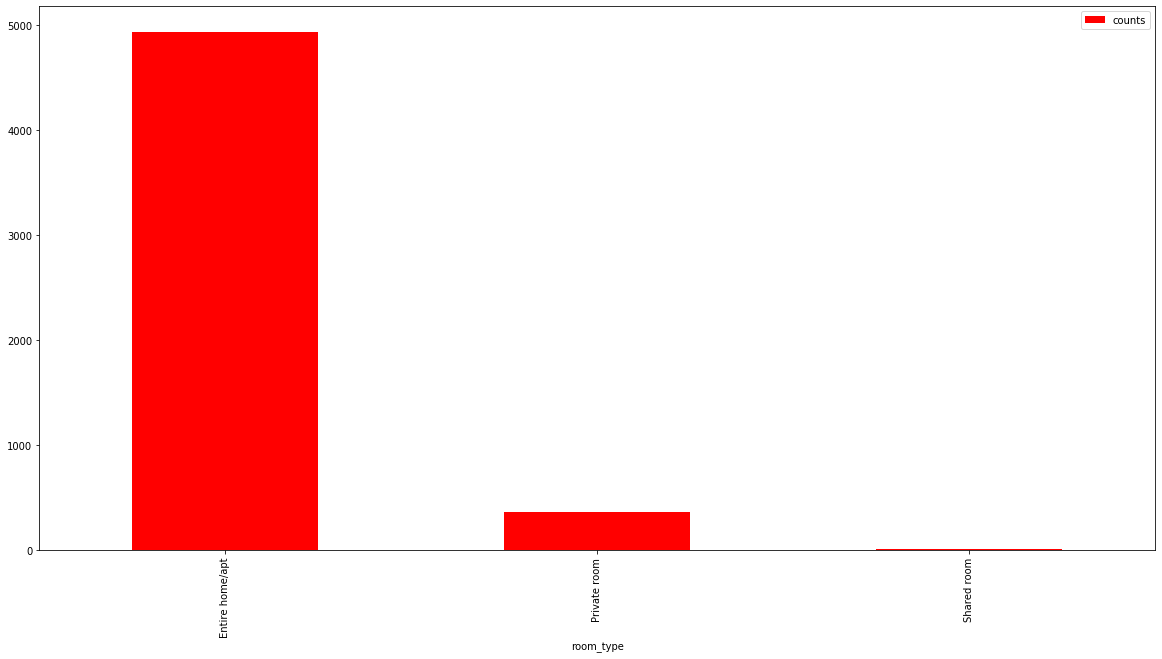

In [68]:
#Creating a new dataframe containing only ids and room_types and also getting unique ids.

id_rooms = train[[ 'id', 'room_type']]
id_rooms = id_rooms.drop_duplicates(subset=['id'])

#Getting counts of every room type.
id_rooms['counts'] = id_rooms.groupby(['room_type'])['id'].transform('count')

#Keeping unique room types and their counts.
id_rooms = id_rooms.drop_duplicates(subset=['room_type'] )
id_rooms = id_rooms[['room_type','counts']]

#Plotting our data
id_rooms.plot(x ='room_type', y='counts', kind = 'bar', figsize=(20,10), color="red")

# Question 2: Graph of Price course 

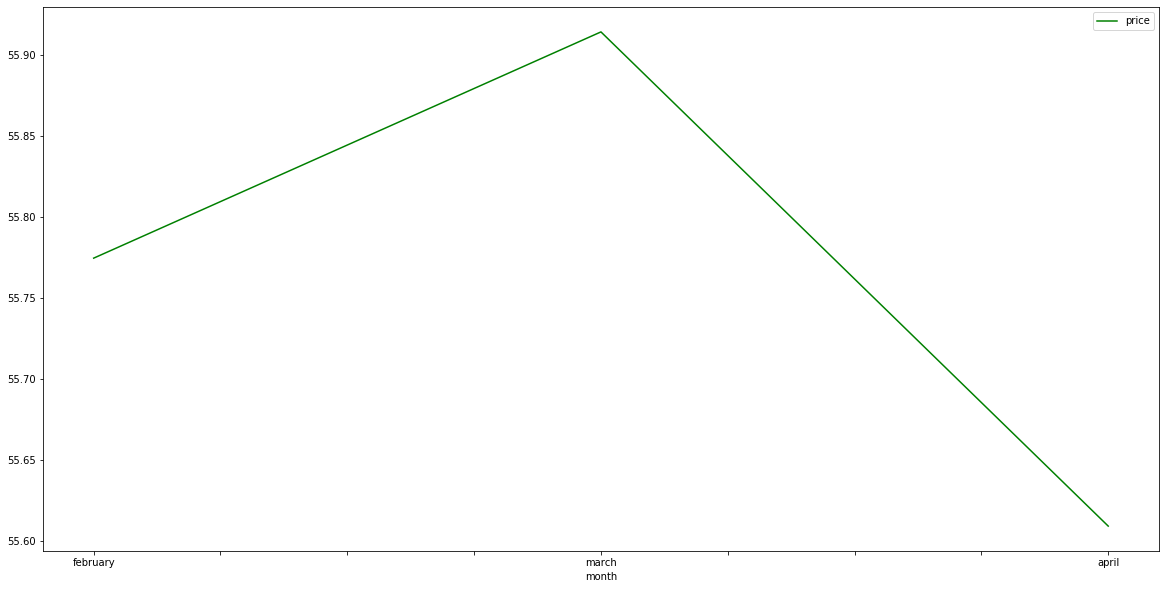

In [69]:
#Getting a dataframe of each month along with the respective average price.
month_prices = train[[ 'month', 'price' ]]

march_only = month_prices[month_prices.month != 'april' ]
march_only = march_only[march_only.month != 'february']
march_mean = march_only["price"].mean()

feb_only = month_prices[month_prices.month != 'april' ]
feb_only = feb_only[feb_only.month != 'march']
feb_mean   = feb_only["price"].mean()

april_only = month_prices[month_prices.month != 'february' ]
april_only = april_only[april_only.month != 'march']
april_mean = april_only["price"].mean()


#Creating a new dataframe with only the months and the respective average price
month = ['february', 'march', 'april']
price = [ feb_mean, march_mean, april_mean ]

list_of_tuples = list(zip(month, price))  

avg_df = pd.DataFrame(list_of_tuples, columns = ['month', 'price']) 


#Plotting our data
avg_df.plot(x ='month', y='price', kind = 'line', figsize=(20,10), color="green")

# Question 3: First five neighborhoods with the most reviews

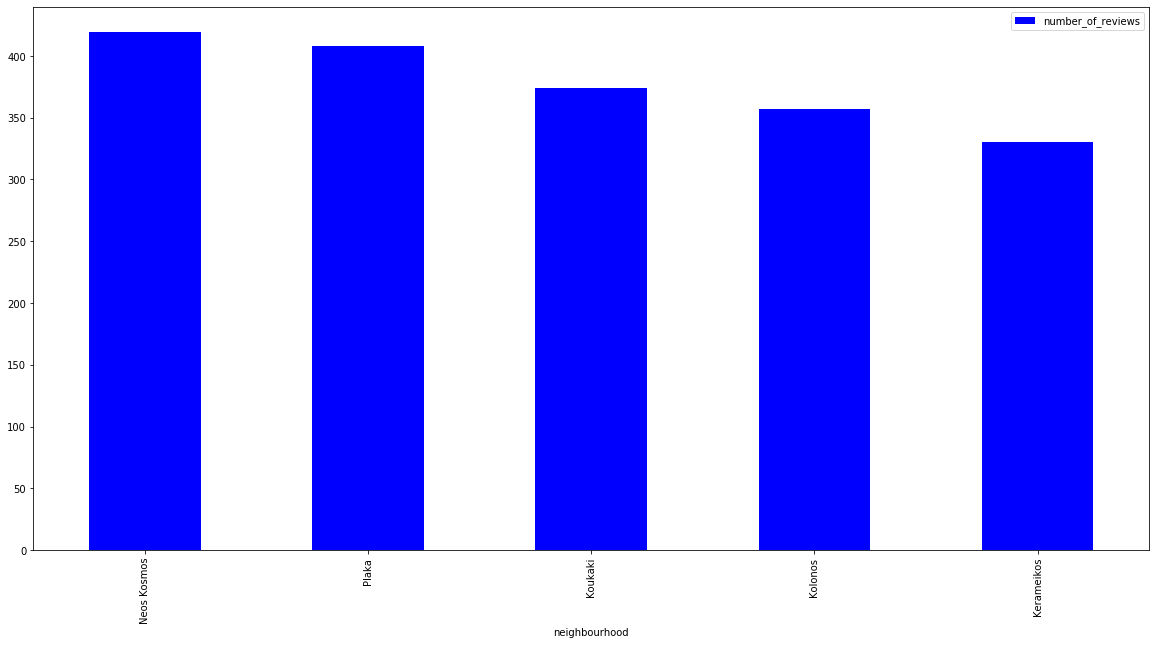

In [70]:
#Creating a new dataframe containing only 'number_of_reviews' and 'neighbourhood' and also getting the unique neighbourhoods.
train['number_of_reviews'] = train['number_of_reviews'].astype(int)
hood_revs = train[[ 'neighbourhood', 'number_of_reviews']].copy()

hood_revs = hood_revs.drop_duplicates(subset=['neighbourhood'])

#Keeping the neighbourhoods with the most reviews.
hood_revs = hood_revs.nlargest(5, ['number_of_reviews']) 

#Plotting our data.
hood_revs.plot(x ='neighbourhood', y='number_of_reviews', kind = 'bar', figsize=(20,10), color="blue")


# Question 4: Neighborhood with the most estates

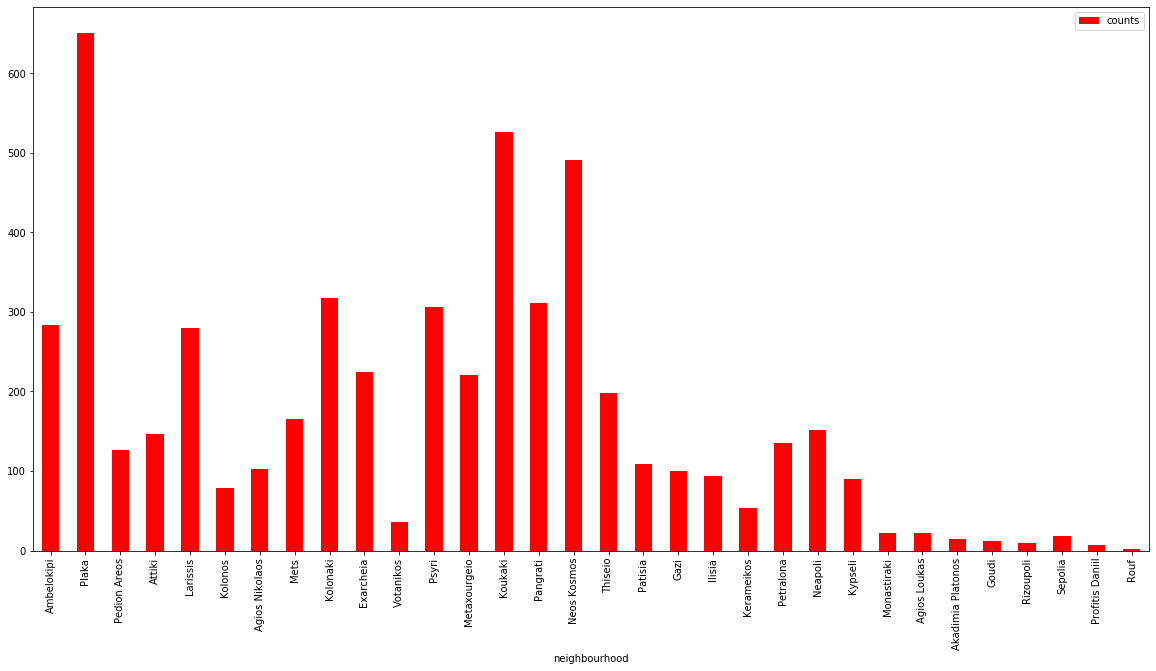

In [71]:
#Creating a new dataframe containing only 'id' and 'neighbourhood' and also getting the unique ids
hood_ids = train[[ 'id', 'neighbourhood']].copy()
hood_ids = hood_ids.drop_duplicates(subset=['id'])

#Getting counts of every neighbourhood.
hood_ids['counts'] = hood_ids.groupby(['neighbourhood'])['id'].transform('count')

#Keeping unique neighbourhoods and their counts.
hood_ids = hood_ids.drop_duplicates(subset=['neighbourhood'] )
hood_ids = hood_ids[['neighbourhood','counts']]

#Plotting our data.
hood_ids.plot(x ='neighbourhood', y='counts', kind = 'bar', figsize=(20,10), color="red")

# Question 5: Estates per neighbourhood and month

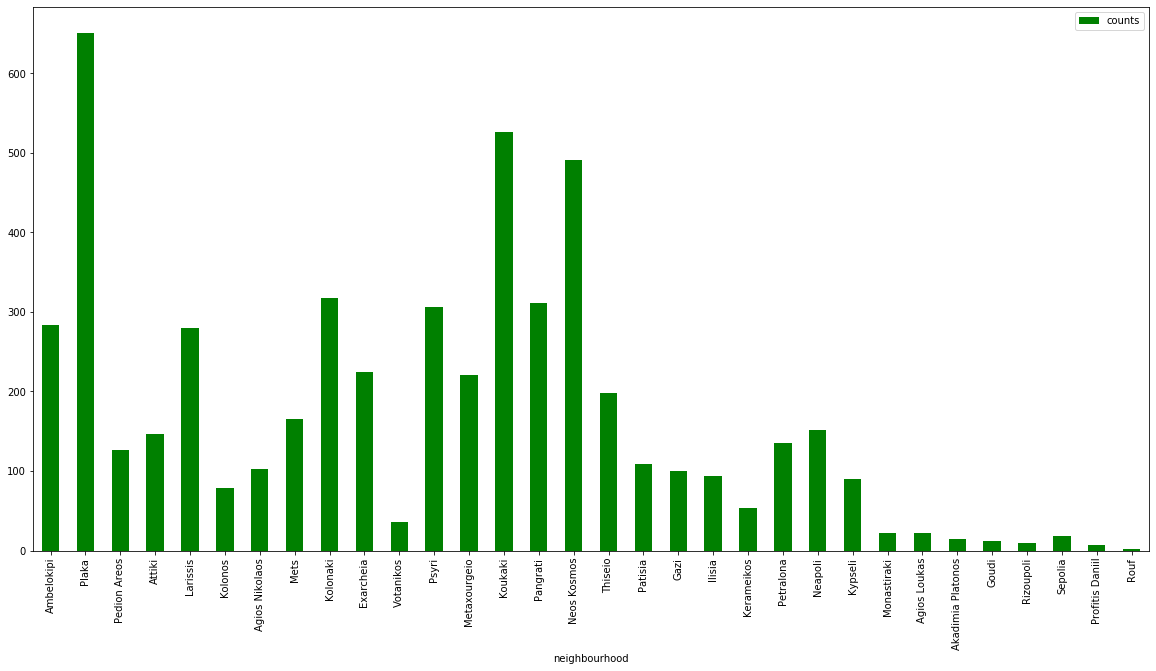

In [72]:
#Creating a new dataframe containing only 'id' and 'neighbourhood' and also getting the unique ids
hood_ids = train[[ 'id', 'neighbourhood']].copy()
hood_ids = hood_ids.drop_duplicates(subset=['id'])

#Getting counts the id counts for each neighbourhood
hood_ids['counts'] = hood_ids.groupby(['neighbourhood'])['id'].transform('count')
hood_ids = hood_ids.drop_duplicates(subset=['neighbourhood'] )

#Removing the ids from the dataframe
hood_counts = hood_ids[['neighbourhood','counts']]

#Plotting our data
hood_counts.plot(x ='neighbourhood', y='counts', kind = 'bar', figsize=(20,10), color="green")



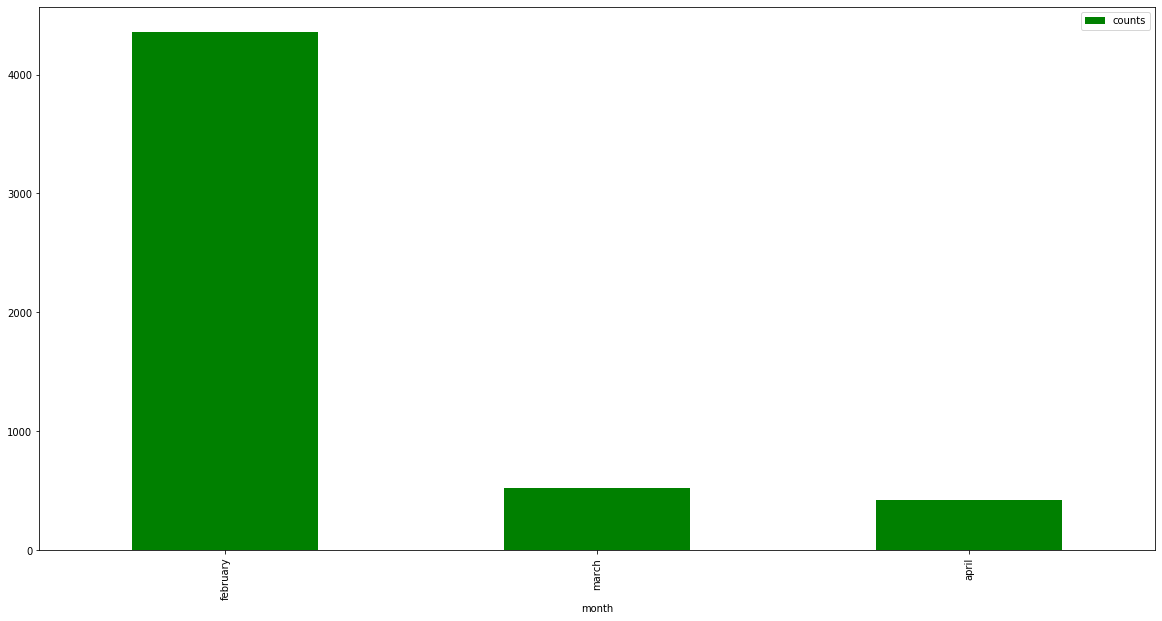

In [73]:
#Same thing for the 'month' column. Note: February has more ids due to the fact that duplicate rows were dropped. Results may vary with a different option.

month_ids = train[[ 'id', 'month']].copy()
month_ids = month_ids.drop_duplicates(subset=['id'])

month_ids['counts'] = month_ids.groupby(['month'])['id'].transform('count')
month_ids = month_ids.drop_duplicates(subset=['month'] )

month_counts = month_ids[['month','counts']]


month_counts.plot(x ='month', y='counts', kind = 'bar', figsize=(20,10), color="green")


# Question 6: Histogram of neighborhood column

<BarContainer object of 32 artists>

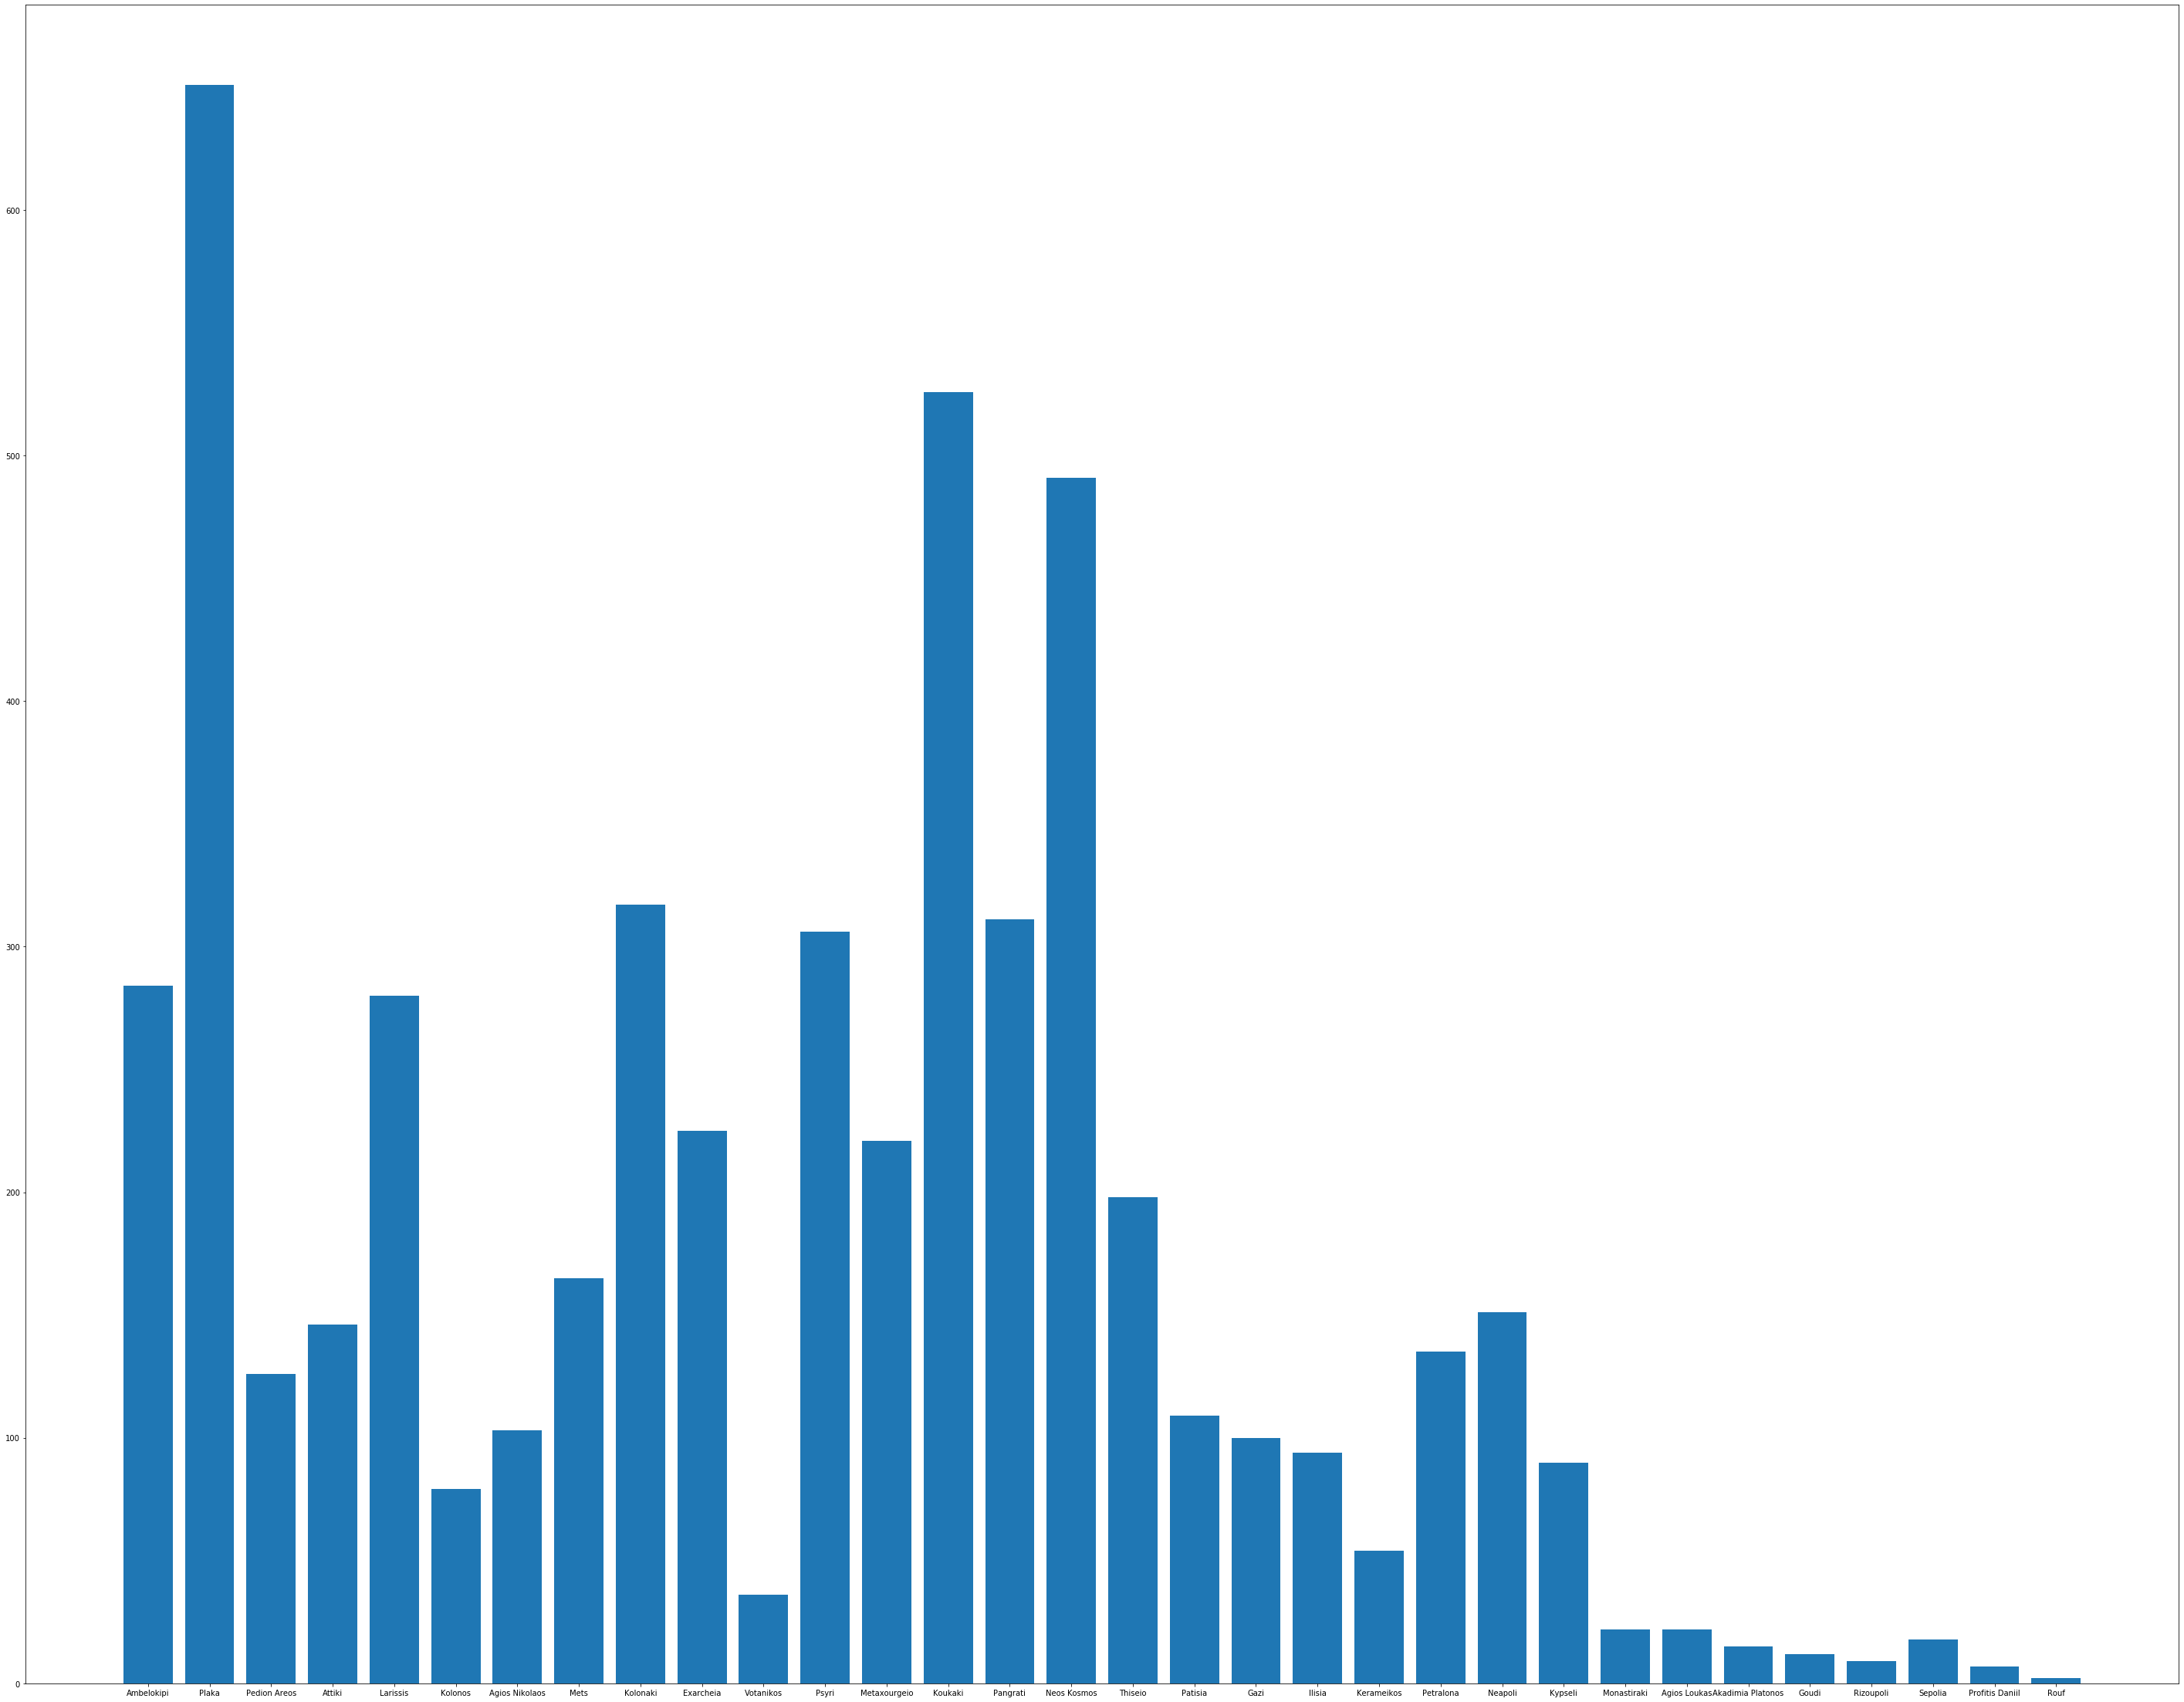

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

#Hood_counts is the dataframe of neighbourhood and the counts of unique ids for each neighbourhood. This dataframe was created in Question 5.

#Here we create a dictionary of the neighbourhoods and their counts and we use plt.bar() to print them in a histogram format.
hood_counts.set_index('neighbourhood')['counts'].to_dict()
mydict = dict(zip(hood_counts.neighbourhood, hood_counts.counts))
plt.figure(figsize=(50,40))
plt.bar(mydict.keys(), mydict.values())


#  

# Question 7: Most frequent room type for each neighbourhood

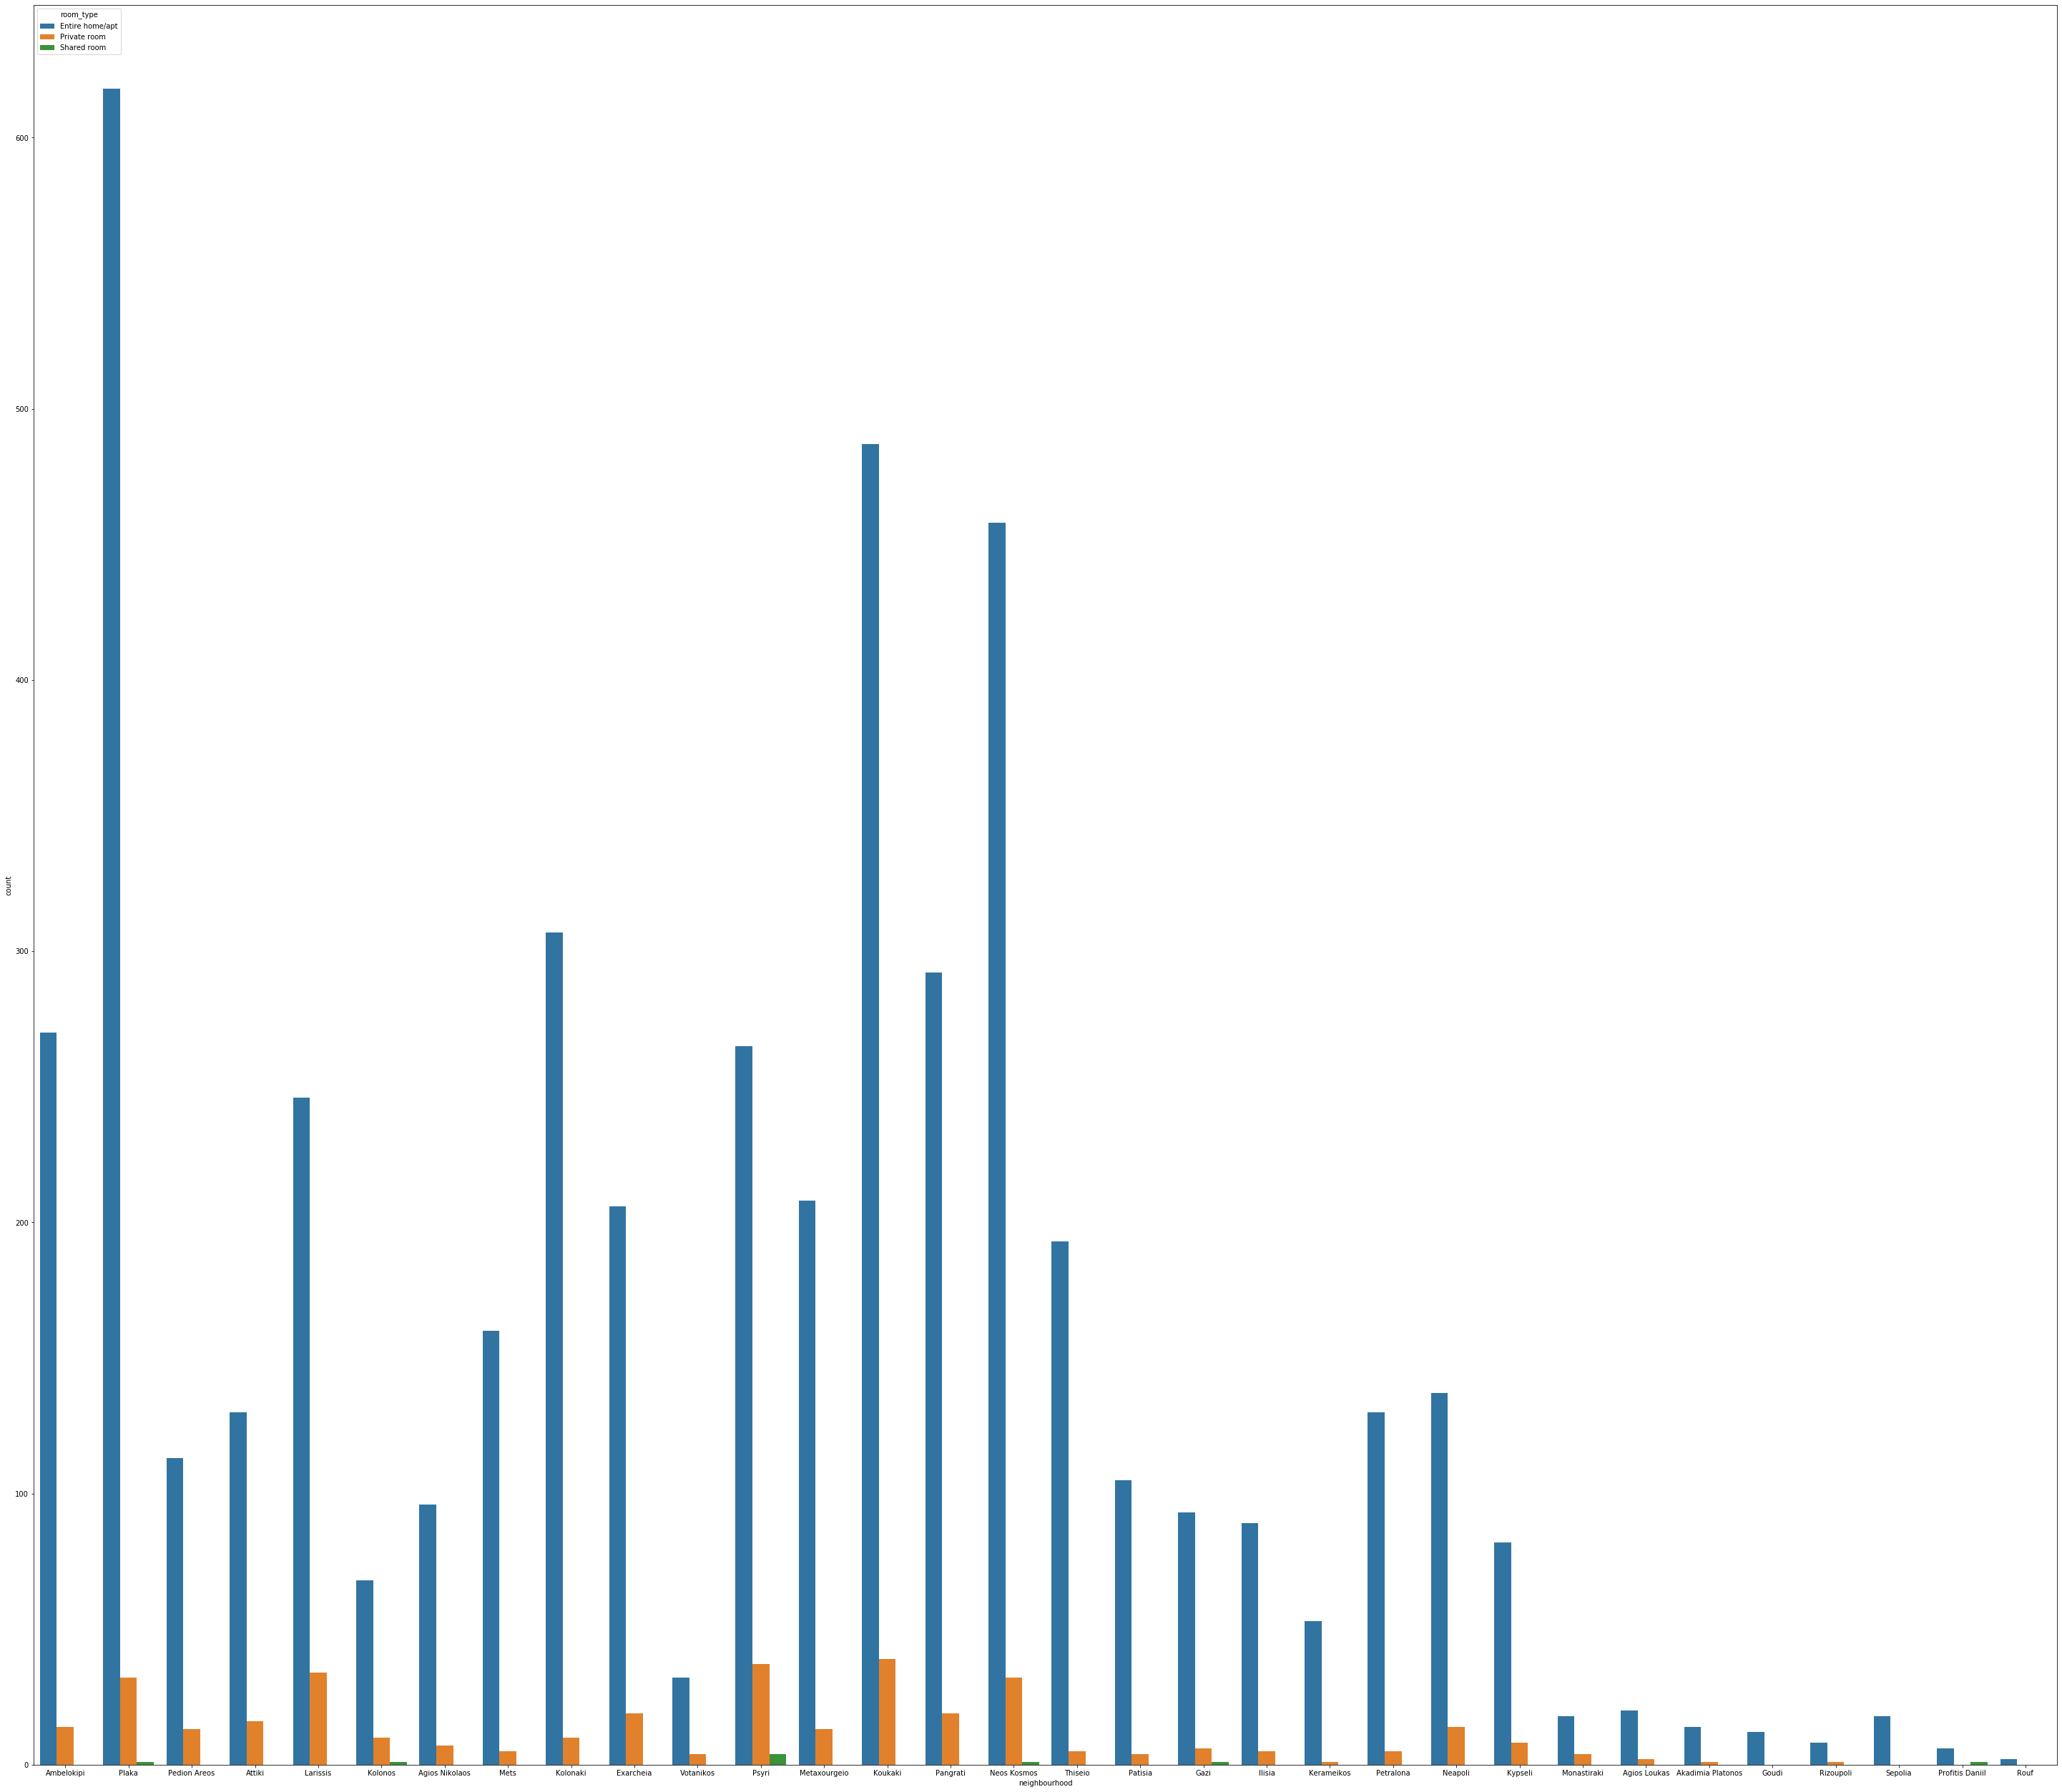

In [75]:
from matplotlib import pyplot


#Creating a new dataframe containing only 'neighbourhood' and 'room_type' and also getting the unique ids
room_hoods1 = train[[ 'id', 'neighbourhood', 'room_type' ]].copy() 
room_hoods1 = room_hoods1.drop_duplicates(subset=['id'])
room_hoods = room_hoods1[[ 'neighbourhood', 'room_type' ]].copy()

#Setting the dimensions for our plot.
a4_dims = (50.7, 45.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

#Using countplot to plot the counts of every room type for each neighbourhood. 
#Since there are a lot of neighbourhoods, you may zoom the following plot to see the results better.
sns.countplot(ax= ax, x="neighbourhood", hue="room_type", data = room_hoods )


#  

# Question 8: Most expensive room type

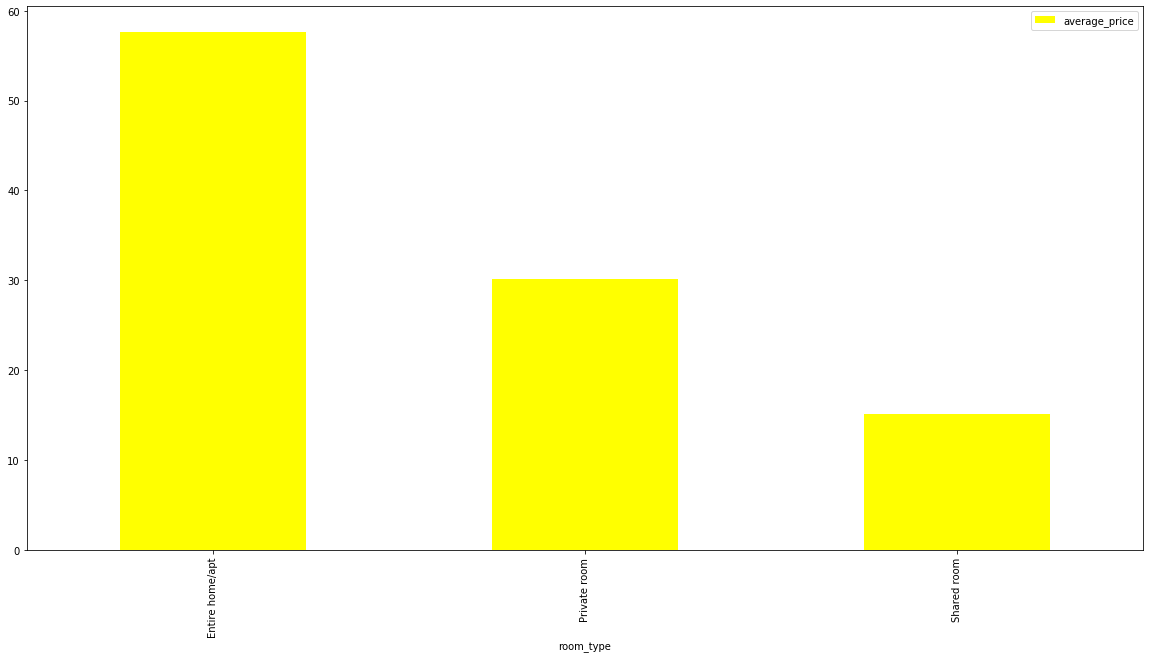

In [78]:
#Creating a new dataframe containing only 'room_type' and 'price' columns.
room_prices = train[[ 'room_type', 'price']].copy()

#Getting the unique room types
room_types = room_prices.drop_duplicates(subset=['room_type'])
room_types_list = room_types['room_type'].tolist()

#Creating a list of dataframes. Each has a unique room_type with its prices.
df_list = []
for room in room_types_list:
    new_df = room_prices.loc[room_prices['room_type'] == room ]
    df_list.append(new_df)
    

#Here we get the average price of every room type and we place them in a list.    
all_means = []
for df in df_list:
    mean = df["price"].mean()
    room = df["room_type"].iloc[0]
    all_means.append((room,mean))

#Finally getting a dataframe which contains only the average price for every room type.
avg_dm = pd.DataFrame(all_means, columns = ['room_type', 'average_price']) 

#Plotting our data.
avg_dm.plot(x ='room_type', y='average_price', kind = 'bar', figsize=(20,10), color="yellow")


#  

# Question 9: Folium Map of our data

In [79]:
#Note: The map could not be loaded after saving and re-opening the .ipynb file.
#As a result, the generated map can be seen at the 'Athens_Map.html' file.

#Getting the necessary columns for a speicific month (March in our case)
locs = train[[ 'month', 'id', 'latitude', 'longitude', 'room_type', 'bed_type']]
locs = locs[locs.month != 'april']
locs = locs[locs.month != 'february']

#Picking a random sample of 500 values in order to reduce lag
locs = locs.sample(n=500)

#Getting a list of our locations
locations = locs[['latitude', 'longitude', 'room_type', 'bed_type']]
location_list = locations.values.tolist()

#Creating our map with latitude and longitude values
for coord in location_list:
    map_ath = folium.Map( location=[ coord[0], coord[1] ], zoom_start = 12 )

#Adding markers for each room. Each marker contains room_type and bed_type     
for coord in location_list:    
    folium.Marker([ coord[0], coord[1] ], popup = "Room Type: " + coord[2] + "; Bed Type: " + coord[3] , icon = folium.Icon(color='green') ).add_to(map_ath)


map_ath.save('Athens_Map.html')

#  

# Question 10: Generating wordclouds

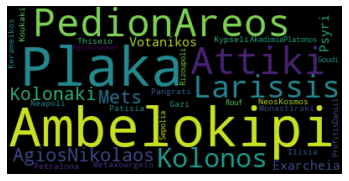

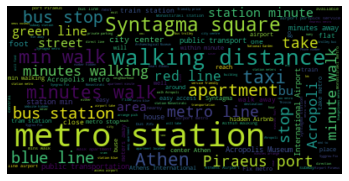

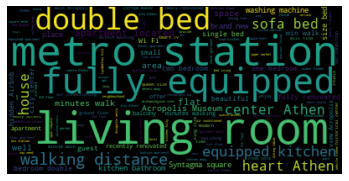

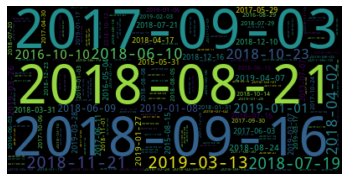

In [80]:
#Getting a unique list of 'neighbourhood' column so it can be passed to WordCloud().generate()
hood_list = train['neighbourhood'].str.replace(" ","").drop_duplicates()
unique_str  = ' '.join(hood_list)
wordcloud = WordCloud().generate(unique_str)

#Displaying the image of 'neighbourhood':
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#Same thing for 'transit' column
trans_list = train['transit'].drop_duplicates()
unique_str2  = ' '.join(trans_list)
wordcloud = WordCloud().generate(unique_str2)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#Same thing for 'description' column
desc_list = train['description'].drop_duplicates()
unique_str3  = ' '.join(desc_list)
wordcloud = WordCloud().generate(unique_str3)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#Used generate_from_frequencies() for 'last_review' because generate() caused errors here
counts = train['last_review'].drop_duplicates().value_counts()
counts.index = counts.index.map(str)
wordcloud = WordCloud().generate_from_frequencies(counts)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


 #  

# Question 12: Some extra questions

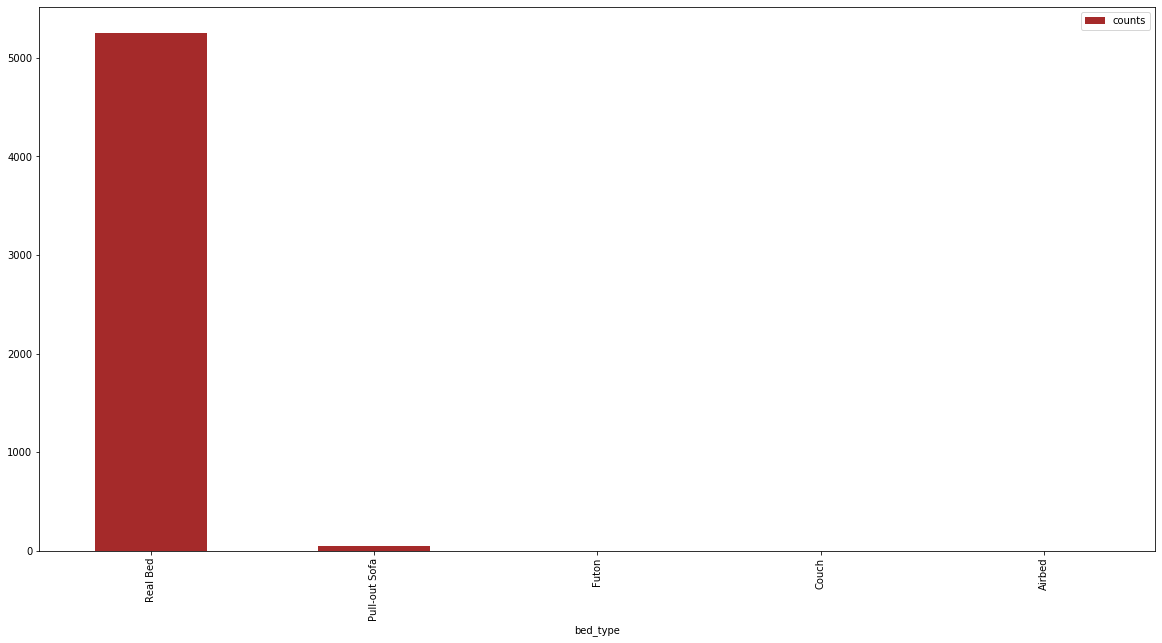

In [81]:
#A) The most common bed_type 
id_beds = train[[ 'id', 'bed_type']].copy()
id_beds = id_beds.drop_duplicates(subset=['id'])

#Getting counts of every bed type.
id_beds['counts'] = id_beds.groupby(['bed_type'])['id'].transform('count')

#Keeping unique bed types and their counts.
id_beds = id_beds.drop_duplicates(subset=['bed_type'] )
id_beds = id_beds[['bed_type','counts']]

#Plotting our data.
id_beds.plot(x ='bed_type', y='counts', kind = 'bar', figsize=(20,10), color="brown")


#  

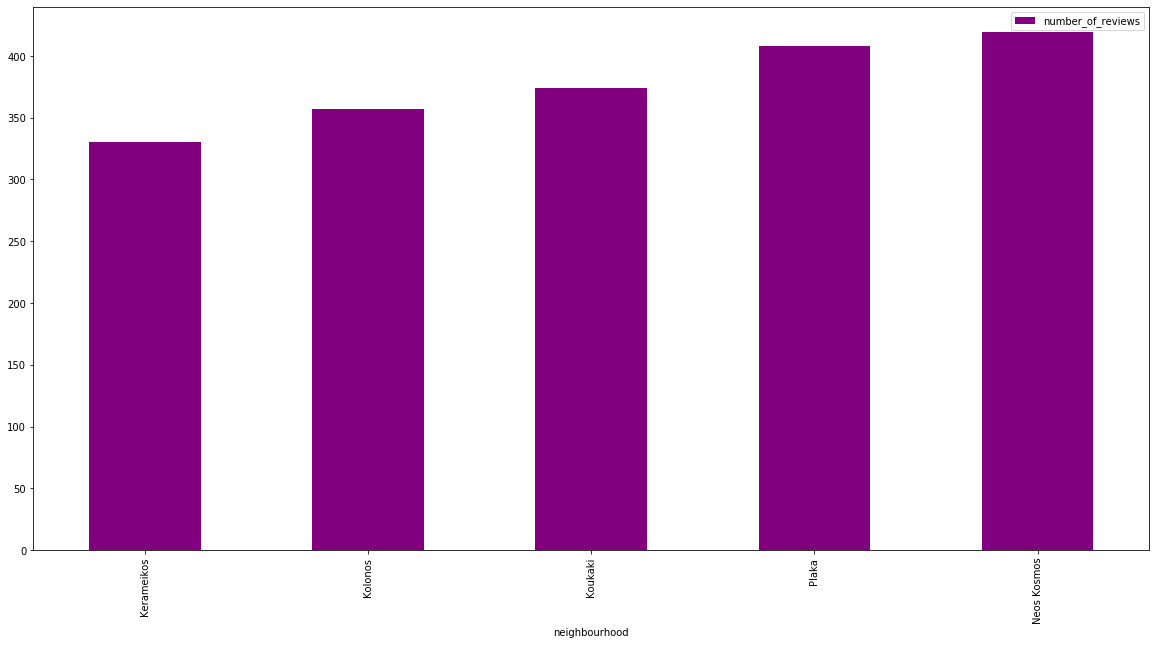

In [82]:
#B) Five neighbourhoods with the least amount of reviews.

#Creating a new dataframe containing only 'number_of_reviews' and 'neighbourhood' and also getting the unique neighbourhoods.
train['number_of_reviews'] = train['number_of_reviews'].astype(int)
hood_revs2 = train[[ 'neighbourhood', 'number_of_reviews']].copy()
hood_revs2 = hood_revs.drop_duplicates(subset=['neighbourhood'])

#Keeping the neighbourhoods with the least amount of reviews.
hood_revs2 = hood_revs.nsmallest(5, ['number_of_reviews']) 

#Plotting our data.
hood_revs2.plot(x ='neighbourhood', y='number_of_reviews', kind = 'bar', figsize=(20,10), color="purple")


#  

# Part 2: Recommendation System

# Introduction: A new wordcloud

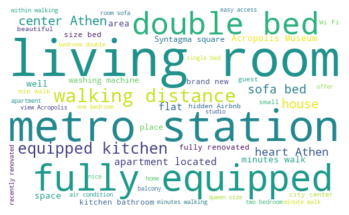

In [86]:
#Creatina a new wordcloud of the description column. 
desc_list = train['description'].drop_duplicates()
unique_str3  = ' '.join(desc_list)

#For this one, we added stopwords, changed the font size, added less max words, added relative_scaling = 1 to make the more frequnt words appear larger, and also changed the background color.   
wordcloud = WordCloud( width = 500, height = 300, stopwords=STOPWORDS, max_font_size=100, max_words = 50, relative_scaling = 1, background_color = 'white' ).generate(unique_str3)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Creating the new column for the following questions of the Recommendation System.
train['name_and_desc'] = train['name'] + ' ' + train['description']
train['name_and_desc'] = train['name_and_desc'].fillna('NULL')



#  

# Question 1: Creating an array of unigrams and bigrams

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Creating a new train dataframe with the columns we need
train2 = train[['id','name_and_desc', 'name', 'description']].copy()
train2 = train2.drop_duplicates(subset=['id'])

#Using the TfidfVectorizer to get the array of unigrams and bigrams for the 'name_and_desc' column. 
tfidf = TfidfVectorizer( stop_words = 'english' , ngram_range=(1,2))
tfs = tfidf.fit_transform(train2['name_and_desc'].values.astype('U'))

features = (tfidf.get_feature_names())
    


#  

# Question 2: Cosine similarity scores and dictionary

In [88]:
from sklearn.metrics.pairwise import cosine_similarity

#Getting a list of our ids
id_list = train2['id'].tolist()

#Getting the array with cosine similaritites using the unigrams and bigrams array from the previous question.
cos_arr = cosine_similarity(tfs) 

#Function which returns the second largest item in a list.
#(We need the second largest here because the first largest item in every cosine similarity pair is the match with its own room id. So we need to skip it.)
def second_largest(lst):
    lst1 = lst
    lst2 = lst1.copy()
    lst2.sort()
    desired_item = lst2[-2]
    return desired_item


#The big list will keep the largest value of each row, and the row/column it was found.
big_list = []
for i, item in enumerate(cos_arr):
    max_val = second_largest(item)
    
    keepj = 0
    for j, k in enumerate(item):
        if k == max_val:
            if i == j:
                continue
            keepj = j
            break
            
    coords = i, keepj
    
    val = max_val, coords
    big_list.append(val)
    

#Getting the 100 largest items from the previous list.
def Nmaxelements(list1, N): 
    final_list = [] 
  
    for i in range(0, N):  
        max1 = 0.0
          
        for j in range(len(list1)):      
            if list1[j][0] > max1: 
                max1 = list1[j][0]; 
                coords = list1[j][1];
                  
        list1.remove((max1,coords)); 
        final_list.append((max1,coords) )
          
    return final_list

    
N = 100
big_list_arg = big_list.copy()
hundred_lst = Nmaxelements(big_list_arg, N) 

#Creating the dictionary using the previous list. Each key (id) in the dictionary will have the id that it has the biggest cosine similarity score.
mydict = dict()
hundred_lst

for item in hundred_lst:
    coords = item[1]
    for i,item in enumerate(id_list):
        if i == coords[0]:
            keep_item = item
            break
    for i,item in enumerate(id_list):
        if i == coords[1]:
            keep_item2 = item
            break
    
    mydict[keep_item] = keep_item2
    

mydict


{32649434: 32650034,
 32650034: 32649434,
 32650458: 32649434,
 27254673: 30009754,
 32027068: 32028288,
 32028288: 32027068,
 31509913: 31560654,
 31560654: 31509913,
 32276334: 32336457,
 32336457: 32276334,
 32337937: 32276334,
 30009754: 27254673,
 10603975: 27162716,
 22074163: 22074541,
 22074541: 22074163,
 22074774: 22074946,
 22074946: 22074774,
 22075076: 22074774,
 27162716: 10603975,
 30284619: 30287707,
 30287707: 30284619,
 31558982: 31560802,
 31560802: 31558982,
 15793210: 27774209,
 25941499: 26092250,
 26092250: 25941499,
 26125014: 27282238,
 27070285: 27177926,
 27177926: 27070285,
 27282238: 26125014,
 27686070: 26125014,
 27736231: 30593649,
 27774209: 15793210,
 30089884: 30341020,
 30268642: 30286826,
 30283317: 30286383,
 30286383: 30283317,
 30286826: 30268642,
 30341020: 30089884,
 30362269: 30089884,
 30363015: 30089884,
 30439676: 30514220,
 30514220: 30439676,
 30593649: 27736231,
 30760835: 30089884,
 30906405: 30089884,
 30980429: 30089884,
 30980510: 30

#  

# Question 3: Recommendation function

In [89]:
#Defining the recommend function.
def recommend(item_id, num):
    
    if num > len(id_list):
        print("We don't have that many rooms!")
        return
    
    
    row = -1
    for i,item in enumerate(id_list):
        if item == item_id:
            row = i
            break
    
    if (row == -1):
        print("This ID doesn't exist!")
        return
    
    
    row_print = train2[train2['id'] == item_id]
    print("Recommending ", num, " listings similar to ", row_print['name'].to_string(index=False))
    print("----------------------------------------------")
    print()
    
    arr = np.array(cos_arr[row])
    
    #Getting a list of our scores from the array we found the id.
    lst1 = cos_arr[row]
    scores = lst1.copy()
    (-scores).sort()
    scores = np.delete(scores, 0)

    #Getting a sorted list of the rows that have the biggest cosine similarity
    idx = (-arr).argsort()[:num+1]
    new_a = np.delete(idx, 0)
    
    #Placing the ids in a list.
    id_list2 = []
    for n in new_a:
        
        for i,item in enumerate(id_list):
            if n == i:
                id_list2.append(item)
                break
    
    #Printing our data.
    for i, idi in enumerate(id_list2):
        
        row = train2[train2['id'] == idi]
        
        print("Name: ", row['name'].to_string(index=False))
        print("Description: ", row['description'].to_string(index=False))
        print("Score: ", scores[i])
        print()
        
    
    
#Calling the function with an example.    
recommend(10595,5)


Recommending  5  listings similar to   96m2, 3BR, 2BA, Metro, WI-FI etc...
----------------------------------------------

Name:   50m2, Metro, WI-FI, cableTV, more
Description:   Athens Furnished Apartment No3 is 1-bedroom ap...
Score:  0.5099479291029655

Name:   47m2, close to metro,cable TV,wi-fi
Description:   AQA No2 is 1-bedroom apartment (47m2)  -excell...
Score:  0.5499436948417361

Name:   75m2, 2-br, metro, wi-fi, cable TV
Description:   Athens Furnished Apartment No4 is 2-bedroom ap...
Score:  0.377551256339992

Name:   Studio, metro, cable tv, wi-fi, etc
Description:   The Studio is an  -excellent located  -close t...
Score:  0.5249554117268664

Name:   AQA No9
Description:   Excellent 1-bedroom apartment on the 2nd floor...
Score:  0.004661001419075092



#  

# Question 4: Finding bigram collocations

In [90]:
import nltk

from nltk.collocations import *


bigram_measures = nltk.collocations.BigramAssocMeasures()

#Transforming the 'name_and_desc' column in a string.
train['name_and_desc'] = train['name_and_desc'].astype(str)
name_desc_list = train['name_and_desc'].tolist()
str1 = ''.join(name_desc_list)

#Using the BigramCollocationFinder to get the 10 most common bigrams.
text = str1
tokens = nltk.wordpunct_tokenize(text)
finder = BigramCollocationFinder.from_words(tokens)
finder.nbest(bigram_measures.pmi, 10)



[('00Phileas', 'Fogg'),
 ('227gr', 'canister'),
 ('<', 'ΝΟΣΟΚΟΜΕΙΟ'),
 ('AMERICAN', 'EMBASSY'),
 ('ANW', 'PATHSIA'),
 ('ATHENIAN', 'SPOT'),
 ('AthinA', 'STREETAPARTMENTS'),
 ('Bassileos', 'Konstantinou'),
 ('CALIFORNIA', 'CAMPERVAN'),
 ('Ceryneian', 'Hind')]